#### Prerequisites

- Basic familiarity with [Numpy](https://numpy.org/doc/stable/user/quickstart.html)
- Basic familiarity with [Pyplot](https://matplotlib.org/stable/tutorials/introductory/pyplot.html)

## Outline

- [Section 0](#section-0): NumPy Tips and Code Clarity
- [Section 1](#section-1): Intro to Linear Regression
- [Section 2](#section-2): Least Squared Loss and Maximum Likelihood
- [Section 3](#section-3): Ridge Regression
- [Section 4](#section-4): LASSO Regression



<a name="section-0"></a>

# Section 0: NumPy Tips and Code Clarity


There are multiple ways in NumPy to do each of the following basic operations:

- Matrix-matrix and matrix-vector product.
- Matrix-matrix and vector-vector element-wise product.
- vector-vector inner and outer products.

Avoid using general functions such as `np.dot` that handles most of these operations depending on the shapes of the input parameters.


Note: to check a function documentation, you can do that inside a Nootbook cell using `?<function_name>`.


In [1]:
import numpy as np

In [2]:
# shape: (2, 2)
A = np.array([[1, 2], [3, 4]])

# shape: (2, 2)
B = np.array([[5, 6], [7, 8]])

# shape: (2, )
v1 =  np.array([5, 6])

# shape: (3, )
v2 = np.array([4, 5, 6])

# shape: (2, )
v3 = np.arange(8, 11)



In [3]:
result_matrix_matrix = np.dot(A, B)
# result_matrix_matrix = A @ B # Better


result_matrix_matrix

array([[19, 22],
       [43, 50]])

In [4]:

result_matrix_vector = np.dot(A, v1)
# result_matrix_vector = A @ v1 # Better
result_matrix_vector

array([17, 39])

In [5]:
result_inner_product = np.dot(v2, v3)
# result_inner_product = np.inner(v2, v3)
result_inner_product

137

**There are several issues in using `np.dot` in the previous cell**. It can be very confusing to read a code with `np.dot` as you are trying to understand what operation is actually intended. The reader is required first to read the documentation of `np.dot` and then probe the shape of the input parameters to interpret the expression.


To avoid confusion, consider the following practice:

- Use the explicit `@` operator for matrix-matrix and matrix-vector products.
- Use the explicit `*` operator for element-wise products or [broadcasted products](https://numpy.org/doc/stable/user/basics.broadcasting.html).
- Use the explicit `np.inner` function for innter product between 1-D vectors, same for `np.outer` function.

When you intend to work with an object as a 1-D vector, make sure you don't have excessive dimensions with size 1 of your array.

In [7]:
# shape: (1, 2)
v4 = np.array([[5, 6]])

# shape: (2, 1)
v5 = np.array([[5], [6]])

# This works due to broadcasting rules.
v4 * v5

array([[25, 30],
       [30, 36]])

In [8]:
f'v4.shape: {v4.shape}, v5.shape: {v5.shape},  v4.ndim: {v4.ndim},  v5.ndim: {v5.ndim}'

'v4.shape: (1, 2), v5.shape: (2, 1),  v4.ndim: 2,  v5.ndim: 2'

To fix this and deal with them as vectors:

In [9]:
v4 = v4.squeeze() # Now shape: (2, )
v5 = v5.squeeze() # Now shape: (2, )

f'v4.shape: {v4.shape}, v5.shape: {v5.shape},  v4.ndim: {v4.ndim},  v5.ndim: {v5.ndim}'


'v4.shape: (2,), v5.shape: (2,),  v4.ndim: 1,  v5.ndim: 1'

In [10]:
v4 * v5

array([25, 36])

General practice to improve readability and avoid unexpected behaviour:

- When possible use explicit expressions instead of general functions like `np.dot`.
- Ensure objects representing 1-D vectors have `ndim==1`. If you are writing a function that deals with vectors and parameters use `assert` statements to make sure the input parameters match what you expect.
- Never use the deprectated `np.matrix` class but always `np.array`.

# Linear Regression


<a name="section-1"></a>

##  Section 1: Intro to Linear regression

*Partly adapted from [Deisenroth, Faisal, Ong (2020)](https://mml-book.github.io/).*

The purpose of this notebook is to practice implementing some linear algebra (equations provided) and to explore some properties of linear regression.

We will solely rely on the Python packages numpy and matplotlib, and you are not allowed to use any package that has a complete linear regression framework implemented (e.g., scikit-learn).


In [11]:
import numpy as np
import matplotlib.pyplot as plt


# Initial global configuration for matplotlib
SMALL_SIZE = 12
MEDIUM_SIZE = 16
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

We consider a linear regression problem of the form
$$
y = \boldsymbol x^T\boldsymbol\beta + \epsilon\,,\quad \epsilon \sim \mathcal N(0, \sigma^2)
$$
where $\boldsymbol x\in\mathbb{R}^{(p+1)}$ are inputs and $y\in\mathbb{R}$ are noisy observations. The parameter vector $\boldsymbol\beta\in\mathbb{R}^{(p+1)}$ parametrizes the function.

We assume we have a training set $(\boldsymbol x_n, y_n)$, $n=1,\ldots, N$. We summarize the sets of training inputs in $\boldsymbol X = [\boldsymbol x_1, \ldots, \boldsymbol x_N]^T$ and corresponding training targets $\boldsymbol y = [y_1, \ldots, y_N]^T$, respectively.

In this tutorial, we are interested in finding parameters $\boldsymbol\beta$ that map the inputs well to the ouputs.

From our lectures, we know that the parameters $\boldsymbol\beta$ found by the following equation are optimal:
$$
\underset{\boldsymbol\beta}{\text{min}} \| \boldsymbol y - \boldsymbol X \boldsymbol\beta \|^2 = \underset{\boldsymbol\beta}{\text{min}} \ \text{L}_{\text{LS}} (\boldsymbol\beta)
$$
where $\text{L}_{\text{LS}}$ is the (ordinary) least squares loss function.
### Dataset generation
We will start with a simple training set, that we define by ourselves.

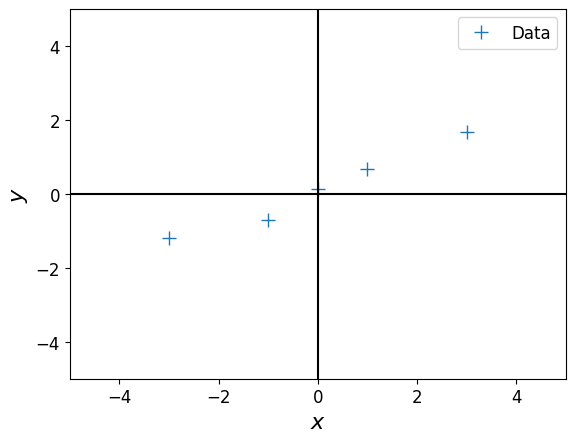

In [12]:
# Define training set
X = np.array([-3, -1, 0, 1, 3]).reshape(-1,1) # 5x1 vector, N=5, D=1
y = np.array([-1.2, -0.7, 0.14, 0.67, 1.67]).reshape(-1,1) # 5x1 vector

# Plot the training set

plt.figure()
plt.plot(X, y, '+', markersize=10, label='Data')
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.axvline(0, color='black')
plt.axhline(0, color='black')
plt.ylim(-5, 5)
plt.xlim(-5,5)
plt.legend()

<a name="section-2"></a>

## Section 2: Least squares loss and Maximum likelihood

From our lectures, we know that the parameters $\boldsymbol\beta$ found by optimizing following equation:
$$
\underset{\boldsymbol\beta}{\text{min}} \| \boldsymbol y - \boldsymbol X \boldsymbol\beta \|^2 = \underset{\boldsymbol\beta}{\text{min}} \ \text{L}_{\text{LS}} (\boldsymbol\beta)
$$
where $\text{L}_{\text{LS}}$ is the (ordinary) least squares loss function. The solution is
$$
\boldsymbol\beta^{*} = (\boldsymbol X^T\boldsymbol X)^{-1}\boldsymbol X^T\boldsymbol y \ \in\mathbb{R}^{(p+1)}\,,
$$
where
$$
\boldsymbol X = [\boldsymbol x_1, \ldots, \boldsymbol x_N]^T\in\mathbb{R}^{N\times (p+1)}\,,\quad \boldsymbol y = [y_1, \ldots, y_N]^T \in\mathbb{R}^N\,.
$$


The same estimate of $\boldsymbol\beta$ we can be obtained by maximum liklihood estimation which gives statistical interpretation of linear regression. In maximum likelihood estimation, we can find the parameters $\boldsymbol\beta^{\mathrm{ML}}$ that maximize the likelihood
$$
p(\boldsymbol y | \boldsymbol X, \boldsymbol\beta) = \prod_{n=1}^N p(y_n | \boldsymbol x_n, \boldsymbol\beta)\,.
$$
From the lecture we know that the maximum likelihood estimator is given by
$$
\boldsymbol\beta^{\text{ML}} = (\boldsymbol X^T\boldsymbol X)^{-1}\boldsymbol X^T\boldsymbol y \, .
$$

Let us compute the maximum likelihood estimate for the given training set.

In [13]:
## EDIT THIS FUNCTION
def max_lik_estimate(X, y):

    # X: N x D matrix of training inputs
    # y: N x 1 vector of training targets/observations
    # returns: maximum likelihood parameters (D x 1)

    N, D = X.shape
    beta_ml = np.linalg.solve(X.T @ X, X.T @ y) ## <-- EDIT THIS LINE
    return beta_ml

In [14]:
# get maximum likelihood estimate
beta_ml = max_lik_estimate(X,y)

Now, make a prediction using the maximum likelihood estimate that we just found.

In [15]:
## EDIT THIS FUNCTION
def predict_with_estimate(X_test, beta):

    # X_test: K x D matrix of test inputs
    # beta: D x 1 vector of parameters
    # returns: prediction of f(X_test); K x 1 vector

    prediction = X_test @ beta ## <-- EDIT THIS LINE

    return prediction

Let's see whether we got something useful:

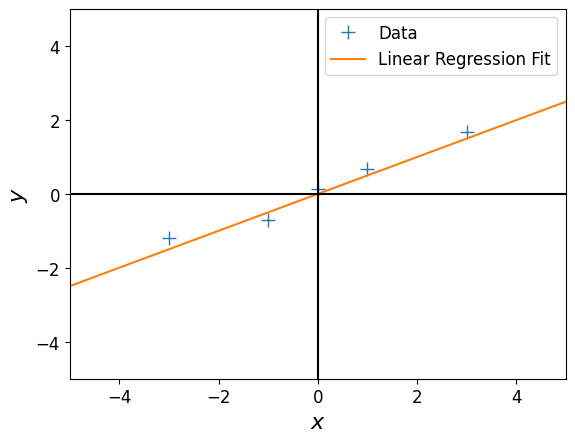

In [16]:
# define a test set
X_test = np.linspace(-5,5,100).reshape(-1,1) # 100 x 1 vector of test inputs
#beta_ml = np.array([[0.2]]) -> changes slope
# predict the function values at the test points using the maximum likelihood estimator
ml_prediction = predict_with_estimate(X_test, beta_ml)

# plot
plt.figure()
plt.plot(X, y, '+', markersize=10, label='Data')
plt.plot(X_test, ml_prediction, label='Linear Regression Fit')
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.axvline(0, color='black')
plt.axhline(0, color='black')
plt.ylim(-5, 5)
plt.xlim(-5,5)
plt.legend()


#### Questions
1. Does the solution above look reasonable?
2. Play around with different values of $\beta$. How do the corresponding functions change?
3. Modify the training targets $\mathcal Y$ and re-run your computation. What changes?

Let us now look at a different training set, where we add 2.0 to every $y$-value, and compute the maximum likelihood estimate.

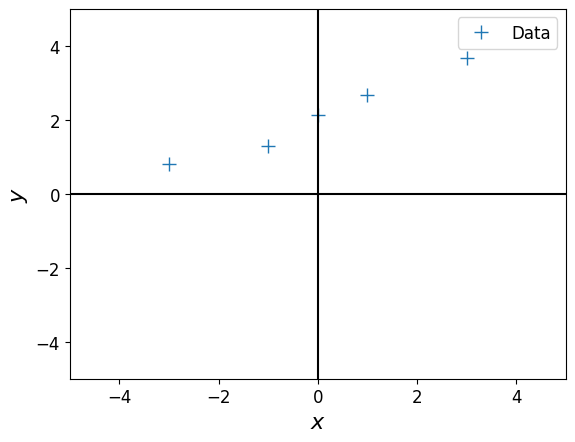

In [17]:
ynew = y + 2.0

plt.figure()
plt.plot(X, ynew, '+', markersize=10, label='Data')
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.axvline(0, color='black')
plt.axhline(0, color='black')
plt.ylim(-5, 5)
plt.xlim(-5,5)
plt.legend()


[[0.499]]


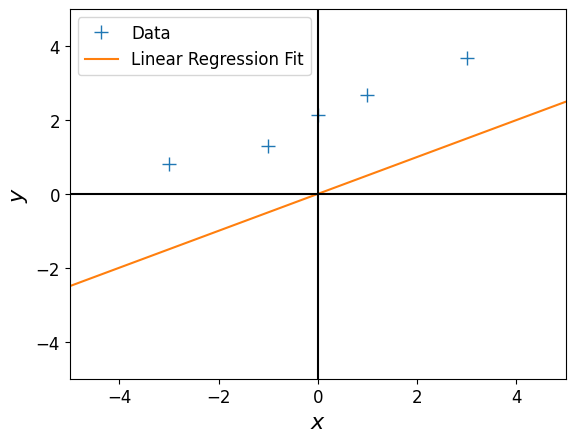

In [18]:
# get maximum likelihood estimate
beta_ml = max_lik_estimate(X, ynew)
print(beta_ml)

# define a test set
X_test = np.linspace(-5,5,100).reshape(-1,1) # 100 x 1 vector of test inputs

# predict the function values at the test points using the maximum likelihood estimator
ml_prediction = predict_with_estimate(X_test, beta_ml)

# plot
plt.figure()
plt.plot(X, ynew, '+', markersize=10, label='Data')
plt.plot(X_test, ml_prediction, label='Linear Regression Fit')
plt.axvline(0, color='black')
plt.axhline(0, color='black')
plt.ylim(-5, 5)
plt.xlim(-5,5)
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.legend()
plt.show()

#### Question:
1. This maximum likelihood estimate doesn't look too good: The orange line is too far away from the observations although we just shifted them by 2. Why is this the case?
2. How can we fix this problem?

Let us now define a linear regression model that is slightly more flexible:
$$
y = \beta_0 + \boldsymbol x^T \boldsymbol\beta_1 + \epsilon\,,\quad \epsilon\sim\mathcal N(0,\sigma^2)
$$

Here, we added an offset (also called intercept) parameter $\beta_0$ to our original model.

#### Question:
1. What is the effect of this bias parameter, i.e., what additional flexibility does it offer?

If we now define the inputs to be the augmented vector $\boldsymbol x_{\text{aug}} = \begin{bmatrix}1\\\boldsymbol x\end{bmatrix}$, we can write the new linear regression model as
$$
y = \boldsymbol x_{\text{aug}}^T\boldsymbol\beta_{\text{aug}} + \epsilon\,,\quad \boldsymbol\beta_{\text{aug}} = \begin{bmatrix}
\beta_0\\
\boldsymbol\beta_1
\end{bmatrix}\,.
$$

In [19]:
N, D = X.shape
X_aug = np.hstack([np.ones((N,1)), X]) # augmented training inputs of size N x (D+1)
beta_aug = np.zeros((D+1, 1)) # new beta vector of size (D+1) x 1

Let us now compute the maximum likelihood estimator for this setting.

_Hint:_ If possible, re-use code that you have already written.

In [20]:
## EDIT THIS FUNCTION
def max_lik_estimate_aug(X_aug, y):

    beta_aug_ml = np.linalg.solve(X_aug.T @ X_aug, X_aug.T @ y) ## <-- EDIT THIS LINE

    return beta_aug_ml

In [21]:
beta_aug_ml = max_lik_estimate_aug(X_aug, ynew)

Now, we can make predictions again:

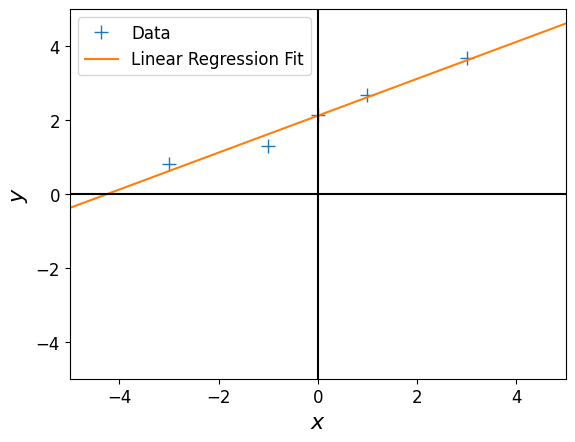

In [22]:
# define a test set (we also need to augment the test inputs with ones)
X_test_aug = np.hstack([np.ones((X_test.shape[0],1)), X_test]) # 100 x (D + 1) vector of test inputs

# predict the function values at the test points using the maximum likelihood estimator
ml_prediction = predict_with_estimate(X_test_aug, beta_aug_ml)

# plot
plt.figure()
plt.plot(X, ynew, '+', markersize=10, label='Data')
plt.plot(X_test, ml_prediction, label='Linear Regression Fit')
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.axvline(0, color='black')
plt.axhline(0, color='black')
plt.ylim(-5, 5)
plt.xlim(-5,5)
plt.legend()
plt.show()

It seems this has solved our problem!
#### Question:
1. Play around with the first parameter of $\boldsymbol\beta_{\text{aug}}$ and see how the fit of the function changes.
2. Play around with the second parameter of $\boldsymbol\beta_{\text{aug}}$ and see how the fit of the function changes.

<a name="section-3"></a>

## Section 3: Ridge regression

From our lectures, we know that ridge regression is an extension of linear regression with least squares loss function, including a (usually small) positive penalty term $\lambda$:
$$
\underset{\boldsymbol\beta}{\text{min}} \| \boldsymbol y - \boldsymbol X \boldsymbol\beta \|^2 + \lambda \| \boldsymbol\beta \|^2 = \underset{\boldsymbol\beta}{\text{min}} \ \text{L}_{\text{ridge}} (\boldsymbol\beta)
$$
where $\text{L}_{\text{ridge}}$ is the ridge loss function. The solution is
$$
\boldsymbol\beta^{*}_{\text{ridge}} = (\boldsymbol X^T\boldsymbol X + \lambda I)^{-1}\boldsymbol X^T\boldsymbol y \, .
$$


This time, we will define a very small training set of only two observations to demonstrate the advantages of ridge regression over least squares linear regression.



In [23]:
X_train = np.array([0.5, 1]).reshape(-1,1)
y_train = np.array([0.5, 1])
X_test = np.array([0, 2]).reshape(-1,1)

Let's define function similar to the one for least squares, but taking one additional argument, our penalty term $\lambda$.

_Hint_: we apply the same augmentation as above with least squares, so the offset is accurately captured.

In [26]:
## EDIT THIS FUNCTION
def ridge_estimate(X, y, penalty):

    # X: N x D matrix of training inputs
    # y: N x 1 vector of training targets/observations
    # returns: maximum likelihood parameters (D x 1)

    N, D = X.shape
    X_aug = np.hstack([np.ones((N,1)), X]) # augmented training inputs of size N x (D+1)
    N_aug, D_aug = X_aug.shape
    I = np.identity(D_aug)
    I[0, 0] = 0
    beta_ridge = np.linalg.solve(X_aug.T @ X_aug + penalty * I, X_aug.T @ y) ## <-- EDIT THIS LINE
    return beta_ridge

Now, we add a bit of Gaussian noise to our training set and apply ridge regression. We should do it a couple of times to be sure about the results (here 10 times).

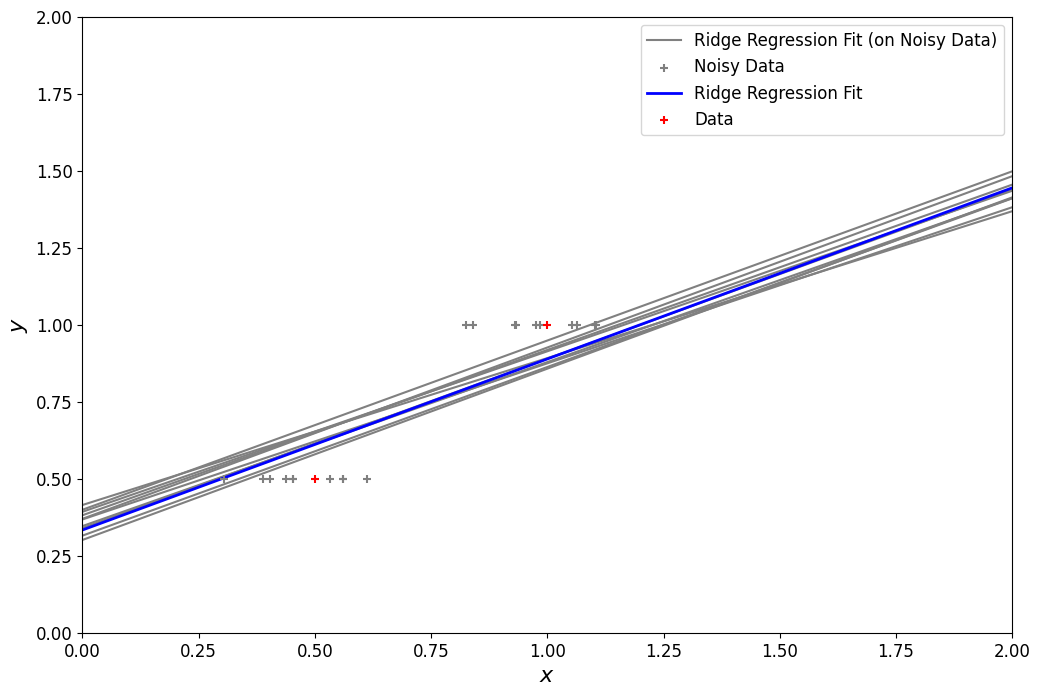

In [27]:
penalty_term = 0.1
fig, ax = plt.subplots(figsize=(12, 8))
X_test_aug = np.hstack([np.ones((X_test.shape[0],1)), X_test])


for i in range(10):
    this_X = 0.1 * np.random.normal(size=(2, 1)) + X_train

    beta_ridge = ridge_estimate(this_X, y_train, penalty=penalty_term)
    ridge_prediction = predict_with_estimate(X_test_aug, beta_ridge)

    ax.plot(X_test, ridge_prediction, color='gray',
            label='Ridge Regression Fit (on Noisy Data)' if i == 0 else '')
    ax.scatter(this_X, y_train, c='gray', marker='+', zorder=10,
               label='Noisy Data' if i == 0 else '')

beta_ridge = ridge_estimate(X_train, y_train, penalty=penalty_term)
ridge_prediction_X = predict_with_estimate(X_test_aug, beta_ridge)

ax.plot(X_test, ridge_prediction_X, linewidth=2, color='blue', label='Ridge Regression Fit')
ax.scatter(X_train, y_train, c='red', marker='+', zorder=10, label='Data')
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.ylim(0, 2)
plt.xlim(0,2)
plt.legend()

Let's compare this to ordinary least squares:

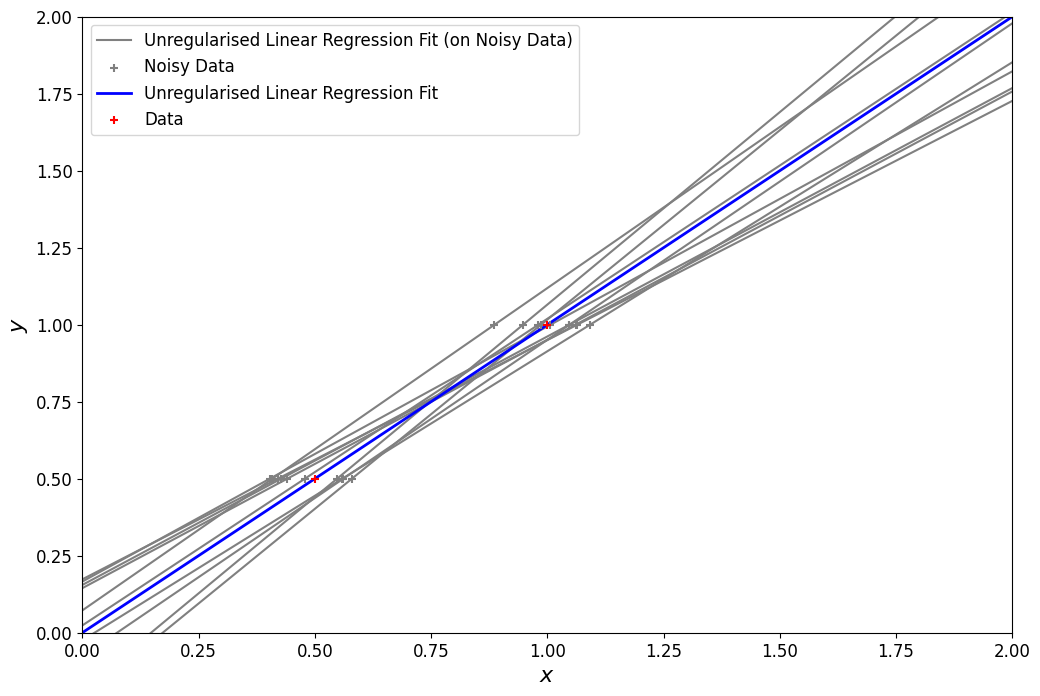

In [28]:
fig, ax = plt.subplots(figsize=(12, 8))
plt.xlim(0.0, 2)
plt.ylim(0.0, 2)

X_train_aug = np.hstack([np.ones((X_test.shape[0],1)), X_train])

X_test_aug = np.hstack([np.ones((X_test.shape[0],1)), X_test])

for i in range(10):
    this_X = 0.1 * np.random.normal(size=(2, 1)) + X_train
    N, D = this_X.shape
    this_X_aug = np.hstack([np.ones((N,1)), this_X])

    beta_aug_ml = max_lik_estimate_aug(this_X_aug, y_train)
    ml_prediction = predict_with_estimate(X_test_aug, beta_aug_ml)


    ax.plot(X_test, ml_prediction, color='gray',
            label='Unregularised Linear Regression Fit (on Noisy Data)' if i == 0 else '')
    ax.scatter(this_X, y_train, c='gray', marker='+', zorder=10,
               label = 'Noisy Data' if i == 0 else '')

beta_aug_ml = max_lik_estimate_aug(X_train_aug, y_train)
ml_prediction_X = predict_with_estimate(X_test_aug, beta_aug_ml)

ax.plot(X_test, ml_prediction_X, linewidth=2, color='blue',
        label='Unregularised Linear Regression Fit')
ax.scatter(X_train, y_train, c='red', marker='+', zorder=10,
           label='Data')
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.ylim(0, 2)
plt.xlim(0,2)
plt.legend()

#### Questions
1. What differences between the two solutions above can you see?
2. **Optional**:
    - play around with different values of the penalty term $\lambda$. How do the corresponding functions change? Which values provide the most reasonable results?
    - Can you replicate your results using [`sklearn.linear_model.Ridge`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html)?
    - Based on sklearn's documentation, can you see any differences in the algorithms that are implemented in sklearn?

<a name="section-4"></a>

## Section 4: LASSO regression

As opposed to the ridge regression which has a penalty term  $\| \boldsymbol\beta \|^2$, LASSO regression introduces $ \| \boldsymbol\beta \|_1 $, (also known as $L_1$ loss). $L_1$ loss is often preferred if we are interested in sparse parameters, i.e. few non-zero paramters. This is generally regarded as a feature selection task, and in high-dimensional problems it helps interpret the learned parameters and their relevance.
However, no closed-form solution exists for LASSO regression as in the standard and ridge regression, so we can use the iterative gradient-descent algorithm.


In LASSO regression the aim is to minimize the following loss:

$L_\text{LASSO}(\boldsymbol{\beta}) = \frac{1}{2N}|| \boldsymbol{y} - \boldsymbol{X} \boldsymbol{\beta}||^2 + \lambda ||\boldsymbol{\beta}||_1$

Where $||\boldsymbol{\beta}||_1 = \sum_{i=1}^p |\beta_i|$


The absolute function $|.|$ adds nonsmoothness to the loss function, which can prevent the gradient-descent to converge properly to the optimal solution, and will keep bouncing around it instead. To solve this, we can use the Huber loss as an alternative to the absolute function. It combines the behaviour of $L_1$ loss except around the zero.

A relaxed optimization can be made by replacing $||\boldsymbol{\beta}||_1$ with the Huber Loss $\sum_{i=1}^p L_c(\beta_i)$, where  $L_c(\beta)$ is defined as:




$L_c (\beta) =
  \begin{cases}
 \frac{1}{2}{\beta^2}                   & \text{for } |\beta| \le c, \\
 c (|\beta| - \frac{1}{2}c), & \text{otherwise.}
\end{cases}
$

The $c$ parameter in Huber determines the range around zero with $L_2$-like behaviour to ensure smoothness and, hence, better convergence.


The piecewise function smooth $L_c (\beta)$ has the gradient:



$\frac{dL_c (\beta)}{d\beta} =
  \begin{cases}
 \beta                   & \text{for } |\beta| \le c, \\
 c\, \text{sgn}(\beta) , & \text{otherwise.}
\end{cases}
$


Now we can minimize the following relaxed function by gradient descent:

$
\begin{align} L_\text{LASSO-Huber}(\boldsymbol{\beta})
&= \frac{1}{2N}|| \boldsymbol{y} - \boldsymbol{X} \boldsymbol{\beta}||^2 + \lambda \sum_i^p L_c(\beta) \\
&= \frac{1}{2N}(\boldsymbol{y} - \boldsymbol{X}\boldsymbol{\beta})^T(\boldsymbol{y} - \boldsymbol{X}\boldsymbol{\beta})  + \lambda \sum_i^p L_c(\beta) \\
&= \frac{1}{2N}\left(\boldsymbol{y}^T\boldsymbol{y} - \boldsymbol{y}^T\boldsymbol{X}\boldsymbol{\beta} - \boldsymbol{\beta}^T\boldsymbol{X}^T  \boldsymbol{y} + \boldsymbol{\beta}^T\boldsymbol{X}^T\boldsymbol{X}\boldsymbol{\beta}\right) + \lambda \sum_i^p L_c(\beta)
\end{align}
$

Which has the gradient

$
\begin{align} \nabla_{\boldsymbol{\beta}} L_\text{LASSO-Huber}
&= \frac{1}{N}\left(\boldsymbol{X}^T\boldsymbol{X}\boldsymbol{\beta} - \boldsymbol{X}^T\boldsymbol{y}\right) + \lambda \nabla_{\boldsymbol{\beta}}L_c(\boldsymbol{\beta})
\end{align}
$

Optimization method:
- **Initialize** $\boldsymbol{\beta}$ with zeros.
- Use Gradient-descent for tuning $\boldsymbol{\beta}$


Implementated in Python as:

In [29]:
import numpy as np

In [31]:
def huber(beta, c = 1e-6):
    return np.where(np.abs(beta) < c,
                    (beta**2)/2.,
                    c*(np.abs(beta) - c/2))

def grad_huber(beta, c = 1e-6):
    g = np.empty_like(beta)
    return  np.where(np.abs(beta) < c,
                    beta,
                    c * np.sign(beta))

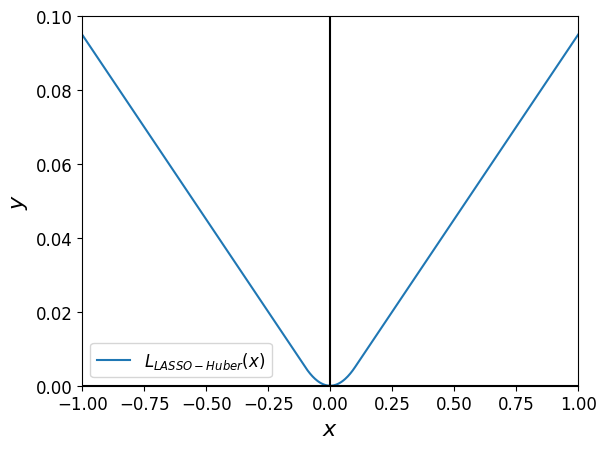

In [43]:
a = np.linspace(-1, 1, 1000)
plt.plot(a, huber(a, c=0.1), label='$L_{LASSO-Huber}(x)$')
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.ylim(0, 0.1)
plt.xlim(-1, 1)
plt.axvline(0, color='black')
plt.axhline(0, color='black')
plt.legend()
plt.show()


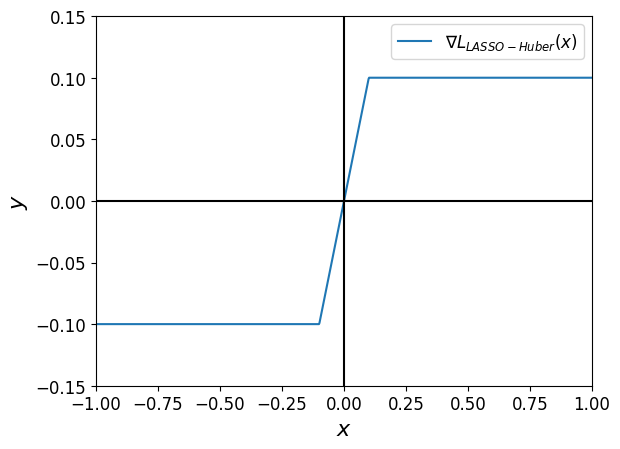

In [40]:
a = np.linspace(-1, 1, 1000)
plt.plot(a, grad_huber(a, c=0.1), label=r'$ \nabla L_{LASSO-Huber}(x)$')
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.ylim(-0.15, 0.15)
plt.xlim(-1, 1)
plt.axvline(0, color='black')
plt.axhline(0, color='black')
plt.legend()

plt.show()

**Try different $c$ values and observe the difference**

### Optimization with gradient-descent

We next implement gradient-descent to solve the optimisation for the LASSO model.

In [49]:
def minimize_ls_huber(X, y, lambd, n_iters = 10000, step_size=5e-5, c_huber=1e-4):
    """
    This function estimates the regression parameters with the relaxed version
    of LASSO regression.
    Args:
    X (np.array): The augmented data matrix with shape (N, p + 1).
    y (np.array): The response column with shape (N, 1).
    lambd (float): The multiplier of the relaxed L1 term.
    n_iters (int): Number of gradient descent iterations.
    step_size (float): The step size in the updating step.
    """
    n, p = X.shape
    # Precomputed products to avoid redundant computations.
    XX = X.T @ X / n
    Xy = X.T @ y / n
    # Initialize beta params with zeros
    beta = np.zeros(p)

    for i in range(n_iters):
        # Compute the gradient of the relaxed LASSO, Huber.
        grad_c = grad_huber(beta, c=c_huber)

        # Should Bias term is not involved in the regularisation.
        grad_c[-1] = 0

        # Compute the gradient of the regularised loss.
        grad = XX @ beta - Xy + lambd * grad_c# <-- EDIT THIS LINE


        # Update beta
        beta = beta - step_size * grad # <-- EDIT THIS LINE

    return beta

To study the feature selection capability of LASSO, we generate a 3 dimensional synthetic data set $X$ where the second dimension does not contribute significantly to the target $y$.

In [50]:
np.random.seed(42)

# Generate random data with three features
X1 = np.random.rand(100)
X2 = np.random.rand(100)  # Insignificant feature (with small theta below)
X3 = np.random.rand(100)
true_theta = np.array([8, 0.5, 9])  # Weights for features
y = X1 * true_theta[0] + X2 * true_theta[1] + X3 * true_theta[2] + np.random.randn(100)

We can compare the ground truth coefficients used to create the synthetic data set to the optimal LASSO coefficients.

In [51]:
# Add bias term
X_aug = np.stack((X1, X2, X3, np.ones(100)), axis=1)

# Run LASSO regression
theta_lasso = minimize_ls_huber(X_aug, y, 5e3, n_iters=15000,
                                step_size=1e-3,
                                c_huber=1e-5)

# Print the result
print("LASSO Regression Coefficients:")
print("Theta (Intercept):", theta_lasso[3])
print("Theta 1:", theta_lasso[0])
print("Theta 2:", theta_lasso[1])
print("Theta 3:", theta_lasso[2])

LASSO Regression Coefficients:
Theta (Intercept): 2.8782140916942134
Theta 1: 5.750205713955047
Theta 2: -0.00455903359194595
Theta 3: 6.342696962159261


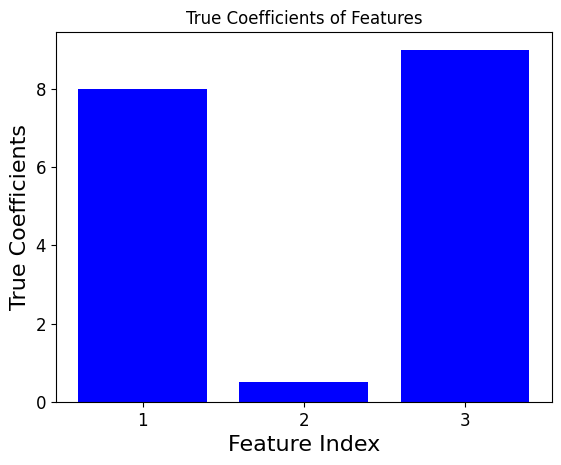

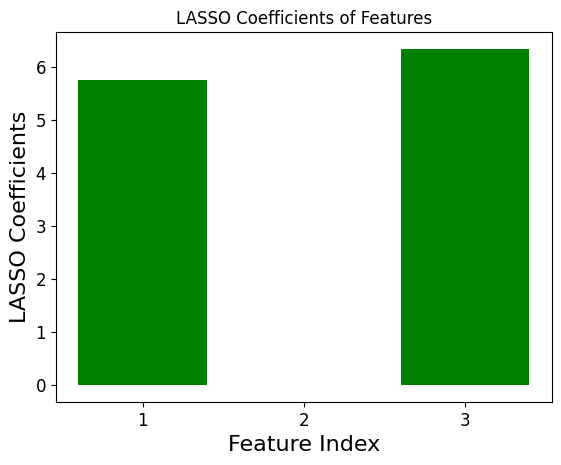

In [52]:
import matplotlib.pyplot as plt

for theta, label in ((true_theta, 'True'), (theta_lasso[:-1], 'LASSO')):
    plt.bar([1,2,3], theta, color='blue' if label == 'True' else 'green')
    plt.xlabel('Feature Index')
    plt.xticks([1,2,3])
    plt.ylabel(f'{label} Coefficients')
    plt.title(f'{label} Coefficients of Features')
    plt.show()

#### Questions

1. Try adding more **insignicant** variables and repeat the experiments. Do you still get the expected sparse solution? If not, what hyperparameters might need a re-tune?

2. Can you observe a clear pattern in how coefficients change as the penalty term $\lambda$ varies? Can you create a plot that shows the trajectory of each coefficient as $\lambda$ changes?

3. **Optional**:
    - Can you replicate your results using [`sklearn.linear_model.Lasso`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html#sklearn.linear_model.Lasso)?
    - Based on sklearn's documentation, can you see any differences in the algorithms that are implemented in sklearn?

